# Notebook for reproducing the neutrino masses and PMNS from data inside GitHub

In [1]:
import pandas as pd
import numpy as np

# Read dataframes with the data. Please adapt your own paths.

In [2]:
Path_to_files = "/home/felipe/JoaoPino/1_LQs_project/Response_v2/To_GitHub"

df_1 = pd.read_csv('{}/Angles.csv'.format(Path_to_files), sep=',')
df_2 = pd.read_csv('{}/Couplings.csv'.format(Path_to_files), sep=',')
df_3 = pd.read_csv('{}/SM_pars.csv'.format(Path_to_files), sep=',')
df_4 = pd.read_csv('{}/Flavour_obs.csv'.format(Path_to_files), sep=',')

# Auxiliar functions

In [3]:
def PMNS(a13, a23, a12, dCP):
    
    """
    Determine the experimental PMNS matrix, based on the angles. PDG parametrization
    
    Inputs:
        -> a13: Angle between 1 and 3 lepton states
        -> a23: Angle between 2 and 2 lepton states
        -> a12: Angle between 1 and 2 lepton states
        -> dCP: CP violating phase
        
    There is numerical errors when picking dCP = 180. It prints out a non-zero imaginary part. It is very small,
    of the order O(1e-16), but causes errors when trying to find solutions
    A quick hack is added to make Exp(-i*180º) = -1
    
    Additional info: https://stackoverflow.com/questions/59021598/numpy-precision-with-exponentials-of-imaginary-numbers
    """

    if dCP == 180:
        
        ad13 = np.deg2rad(a13)
        ad23 = np.deg2rad(a23)
        ad12 = np.deg2rad(a12)
        ddCP = np.deg2rad(dCP)
        Exp1 = np.round(np.exp(-1j*ddCP))
        Exp2 = np.round(np.exp(+1j*ddCP))


        R1 = np.array([[1,0,0], [0,np.cos(ad23),np.sin(ad23)], [0,-np.sin(ad23),np.cos(ad23)]])
        R2 = np.array([[np.cos(ad13), 0, np.sin(ad13)*Exp1], [0,1,0], [-np.sin(ad13)*Exp2, 0, np.cos(ad13)]])
        R3 = np.array([[np.cos(ad12), np.sin(ad12), 0], [-np.sin(ad12), np.cos(ad12), 0], [0,0,1]])
    
    else:
        
        ad13 = np.deg2rad(a13)
        ad23 = np.deg2rad(a23)
        ad12 = np.deg2rad(a12)
        ddCP = np.deg2rad(dCP)

        R1 = np.array([[1,0,0], [0,np.cos(ad23),np.sin(ad23)], [0,-np.sin(ad23),np.cos(ad23)]])
        R2 = np.array([[np.cos(ad13), 0, np.sin(ad13)*np.exp(-1j*ddCP)], [0,1,0], [-np.sin(ad13)*np.exp(1j*ddCP), 0, np.cos(ad13)]])
        R3 = np.array([[np.cos(ad12), np.sin(ad12), 0], [-np.sin(ad12), np.cos(ad12), 0], [0,0,1]])
        
    Vpmns = R1 @ R2 @ R3
    
    return Vpmns

def CKM (s12, s13, s23, d):
    
    """
    Determine the experimental CKM matrix, based on the standard parameterization
    
    Inputs:
        -> s12: sine of the angle between 1 and 2 quark states
        -> s13: sine of the angle between 1 and 3 quark states
        -> s23: sine of the angle between 2 and 3 quark states
        -> d: CP violating phase
    """
    
    c12 = np.sqrt(1 - s12**2)
    c13 = np.sqrt(1 - s13**2)
    c23 = np.sqrt(1 - s23**2)
    
    R1 = np.array([[1,0,0],[0,c23,s23],[0,-s23,c23]])
    R2 = np.array([[c13,0,s13*np.exp(-1j*d)],[0,1,0],[-s13*np.exp(1j*d),0,c13]])
    R3 = np.array([[c12,s12,0],[-s12,c12,0],[0,0,1]])
    
    Vckm = R1 @ R2 @ R3
    
    return Vckm

#Neutrino one-loop mass formula. Corresponds to equation (5) in the main text
def Neutrino_oneloop(i, j, Omega, Theta, VCKM, v, a1, md, mS1, mS2):
    
    """
    Computes the loop function for the neutrino mass matrix. Takes as input
    the Yukawa matrices, Omega and Theta, the CKM mixing matrix, the cubic term
    a1, the vaccuum expectation value, the leptoquark masses (mS1 and mS2) and the
    down-type quark masses.
    
    """
    
    Cte = (3*alpha1*v)/(16*np.sqrt(2)*(mS2**2 - mS1**2)*np.pi**2)*np.log(mS2**2/mS1**2)
    
    F = Cte*sum(md[a]*VCKM[a,m]*(Theta[i][m]*Omega[j][a] + Theta[j][m]*Omega[i][a]) for m in range(3) for a in range(3)) 
    
    return F

def eigen(A):
    eigenValues, eigenVectors = np.linalg.eig(A)
    idx = np.argsort(np.abs(eigenValues))
    eigenValues = np.abs(eigenValues[idx])
    eigenVectors = eigenVectors[:,idx].T
    return (eigenValues, eigenVectors)


# Calculating the neutrino masses and mixing. Please note that charged leptons are always diagonal! 

In [4]:
#It will pick a random point from the dataframe
loc = np.random.randint(0, len(df_1))

VCKM = CKM (s12 = df_1['s12q'].iloc[loc], s13 = df_1['s13q'].iloc[loc], s23 = df_1['s23q'].iloc[loc], d = df_1['DqCP'].iloc[loc])
alpha1 = df_2['a1'].iloc[loc]
mS1 = df_2['mS1'].iloc[loc]
mS2 = df_2['mS2'].iloc[loc]
v = df_3['v'].iloc[loc]
md = np.array([df_3['md'].iloc[loc], df_3['ms'].iloc[loc], df_3['mb'].iloc[loc]])

Theta = np.array([[complex(df_2['Theta11'].iloc[loc]), complex(df_2['Theta12'].iloc[loc]), complex(df_2['Theta13'].iloc[loc])],
                  [complex(df_2['Theta21'].iloc[loc]), complex(df_2['Theta22'].iloc[loc]), complex(df_2['Theta23'].iloc[loc])],
                  [complex(df_2['Theta31'].iloc[loc]), complex(df_2['Theta32'].iloc[loc]), complex(df_2['Theta33'].iloc[loc])]])

Omega = np.array([[complex(df_2['Omega11'].iloc[loc]), complex(df_2['Omega12'].iloc[loc]), complex(df_2['Omega13'].iloc[loc])],
                  [complex(df_2['Omega21'].iloc[loc]), complex(df_2['Omega22'].iloc[loc]), complex(df_2['Omega23'].iloc[loc])],
                  [complex(df_2['Omega31'].iloc[loc]), complex(df_2['Omega32'].iloc[loc]), complex(df_2['Omega33'].iloc[loc])]])

#Calculate the neutrino mass matrix
Mnu11 = Neutrino_oneloop(i=0, j = 0, Omega = Omega, Theta = Theta, VCKM = VCKM, v = v, a1 = alpha1, md = md, mS1 = mS1, mS2 = mS2)
Mnu12 = Neutrino_oneloop(i=0, j = 1, Omega = Omega, Theta = Theta, VCKM = VCKM, v = v, a1 = alpha1, md = md, mS1 = mS1, mS2 = mS2)
Mnu13 = Neutrino_oneloop(i=0, j = 2, Omega = Omega, Theta = Theta, VCKM = VCKM, v = v, a1 = alpha1, md = md, mS1 = mS1, mS2 = mS2)
Mnu21 = Neutrino_oneloop(i=1, j = 0, Omega = Omega, Theta = Theta, VCKM = VCKM, v = v, a1 = alpha1, md = md, mS1 = mS1, mS2 = mS2)
Mnu22 = Neutrino_oneloop(i=1, j = 1, Omega = Omega, Theta = Theta, VCKM = VCKM, v = v, a1 = alpha1, md = md, mS1 = mS1, mS2 = mS2)
Mnu23 = Neutrino_oneloop(i=1, j = 2, Omega = Omega, Theta = Theta, VCKM = VCKM, v = v, a1 = alpha1, md = md, mS1 = mS1, mS2 = mS2)
Mnu31 = Neutrino_oneloop(i=2, j = 0, Omega = Omega, Theta = Theta, VCKM = VCKM, v = v, a1 = alpha1, md = md, mS1 = mS1, mS2 = mS2)
Mnu32 = Neutrino_oneloop(i=2, j = 1, Omega = Omega, Theta = Theta, VCKM = VCKM, v = v, a1 = alpha1, md = md, mS1 = mS1, mS2 = mS2)
Mnu33 = Neutrino_oneloop(i=2, j = 2, Omega = Omega, Theta = Theta, VCKM = VCKM, v = v, a1 = alpha1, md = md, mS1 = mS1, mS2 = mS2)
Mnu = np.array([[Mnu11, Mnu12, Mnu13],[Mnu21, Mnu22, Mnu23],[Mnu31, Mnu32, Mnu33]])

Mnu_diag, UPMNS = eigen(Mnu)

print("Neutrino masses: \n\n", Mnu_diag)
print("PMNS mixing matrix: \n\n", np.abs(UPMNS))

#PMNS and mass difference conditions. Cond_PMNS must be true
Cond_PMNS = ((0.801 <= np.round(np.abs(UPMNS[0,0]),3) <= 0.845) and \
                    (0.513 <= np.round(np.abs(UPMNS[0,1]),3) <= 0.579) and \
                    (0.144 <= np.round(np.abs(UPMNS[0,2]),3) <= 0.156) and \
                    (0.244 <= np.round(np.abs(UPMNS[1,0]),3) <= 0.499) and \
                    (0.505 <= np.round(np.abs(UPMNS[1,1]),3) <= 0.693) and \
                    (0.631 <= np.round(np.abs(UPMNS[1,2]),3) <= 0.768) and \
                    (0.272 <= np.round(np.abs(UPMNS[2,0]),3) <= 0.518) and \
                    (0.471 <= np.round(np.abs(UPMNS[2,1]),3) <= 0.669) and \
                    (0.623 <= np.round(np.abs(UPMNS[2,2]),3) <= 0.761) and \
                    (np.round(((Mnu_diag[1]*1e9)**2 - (Mnu_diag[0]*1e9)**2),7) > (7.42 - 3*0.20)*1e-5) and \
                    (np.round(((Mnu_diag[1]*1e9)**2 - (Mnu_diag[0]*1e9)**2),7) < (7.42 + 3*0.20)*1e-5) and \
                    (np.round(((Mnu_diag[2]*1e9)**2 - (Mnu_diag[1]*1e9)**2),8) > (2.510 - 3*0.027)*1e-3) and \
                    (np.round(((Mnu_diag[2]*1e9)**2 - (Mnu_diag[1]*1e9)**2),8) < (2.510 + 3*0.027)*1e-3))
print("\n")
print("PMNS and mass conditions:", Cond_PMNS)

Neutrino masses: 

 [1.47612717e-16 8.43100863e-12 5.05754004e-11]
PMNS mixing matrix: 

 [[0.83551619 0.53011578 0.14453355]
 [0.28988106 0.64872825 0.70364809]
 [0.46677795 0.54601183 0.69569348]]


PMNS and mass conditions: True


# As one can see, the correct masses and PMNS mixing is reproduced from the data provided in the GitHub page

# You can then use this to make some cool plots. As example, this is the code for generating the $R_D \mathrm{vs.} R_{D^*}$ plot of the paper

In [5]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

mpl.rcParams['text.usetex']=True 
mpl.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
plt.rcParams.update({'font.size': 20})
mpl.rcParams["legend.framealpha"] = 1.0
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.figsize"] = [7.5, 4.5]

In [6]:
#Get best fit points. Also inside the github page
Path_to_best = '/home/felipe/JoaoPino/1_LQs_project/Response_v2/Best_fits'
df_a = pd.read_csv('{}/All_SM/Flavour_obs.csv'.format(Path_to_best), sep=',')
df_b = pd.read_csv('{}/SM_plus_NP/Flavour_obs.csv'.format(Path_to_best), sep=',')
df_c = pd.read_csv('{}/All_NP/Flavour_obs.csv'.format(Path_to_best), sep=',')

In [7]:
RD = 0.339
RD_star = 0.295
sigma = np.array([0.026+0.014, 0.010+0.010])
rho = np.array([[1, -0.38],[-0.38, 1]])

cov = np.diag(sigma) @ rho @ np.diag(sigma)

lamb, v = np.linalg.eig(cov)
lamb = np.sqrt(lamb)

In [8]:
xs = df_4['RD']
ys = df_4['RD_star']
zs = df_4['RKnunu'] 

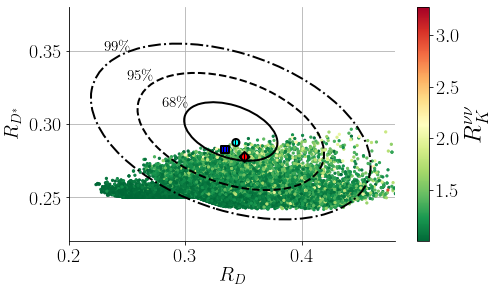

In [9]:
ax = plt.subplot(111)

scat = ax.scatter(x=xs, y=ys, s=5.0, c=zs, marker="o", cmap="RdYlGn_r", rasterized=True)
colorb=plt.colorbar(scat,pad=0.05,fraction=0.2)
colorb.set_label(r'$R_K^{\nu\nu}$',labelpad=10.0, fontsize=25, rotation=90.)


ell1 = Ellipse(xy=(RD, RD_star),
              width=lamb[0]*1*2, height=lamb[1]*1*2,
              angle=np.degrees(np.arctan2(*v[:,0][::-1])),
              alpha=1.0,
              edgecolor='k',
              fc='None',
              lw=2.0,
              ls = '-',
              zorder=2)
ell2 = Ellipse(xy=(RD, RD_star),
              width=lamb[0]*2*2, height=lamb[1]*2*2,
              angle=np.degrees(np.arctan2(*v[:,0][::-1])),
              alpha=1.0,
              edgecolor='k',
              fc='None',
              lw=2.0,
              ls = '--',
              zorder=2)
ell3 = Ellipse(xy=(RD, RD_star),
              width=lamb[0]*3*2, height=lamb[1]*3*2,
              angle=np.degrees(np.arctan2(*v[:,0][::-1])),
              alpha=1.0,
              edgecolor='k',
              fc='None',
              lw=2.0,
              ls = '-.',
              label='Ola',
              zorder=2)

ax.add_artist(ell1)
ax.add_artist(ell2)
ax.add_artist(ell3)

xlikeS = df_a['RD'].iloc[0]
ylikeS = df_a['RD_star'].iloc[0]

xlikeS_T = df_b['RD'].iloc[0]
ylikeS_T = df_b['RD_star'].iloc[0]

xlikeS_Tg2 = df_c['RD'].iloc[0]
ylikeS_Tg2 = df_c['RD_star'].iloc[0]

plt.scatter(xlikeS, ylikeS, marker = "D", color='red', edgecolor='black', hatch = '||||', s=50, linewidth=2.0)
plt.scatter(xlikeS_T, ylikeS_T, marker = "o", color='cyan', edgecolor='black', hatch = '||||', s=50, linewidth=2.0)
plt.scatter(xlikeS_Tg2, ylikeS_Tg2, marker = "s", color='blue', edgecolor='black', hatch = '||||', s=50, linewidth=2.0)

plt.annotate('$68\%$', xy=(0.28,0.312), rotation=0, fontsize=15)
plt.annotate('$95\%$', xy=(0.25,0.33), rotation=0, fontsize=15)
plt.annotate('$99\%$', xy=(0.23,0.35), rotation=0, fontsize=15)

plt.xlim([0.2, 0.48])
plt.ylim([0.22, 0.38])
plt.xlabel('$R_{D}$')
plt.ylabel('$R_{D^*}$')
ax.set_axisbelow(True)
plt.grid()
plt.tight_layout()
plt.show()

#plt.savefig('/home/felipe/JoaoPino/1_LQs_project/Response_v2/Plots/RDstar_vs_RD_RKnunu.png', bbox_inches='tight', dpi=1000.0)
#plt.savefig('/home/felipe/JoaoPino/1_LQs_project/Response_v2/Plots/RDstar_vs_RD_RKnunu.pdf', bbox_inches='tight', dpi=500.0)